In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

In [8]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]


In [9]:
engine_count = np.max(engine_data["engine"])
ship_count = np.max(ship_data["ship"])
max_age = np.max(age_data["age"])
data_count = y_data.shape[0]
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

# gaussian process model

In [4]:
gp_model_dir = "gaussian_process/models/hier_gp_weak/hier_gp_weak.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussian_process/stancode/hier_gp_weak


In [5]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [6]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


CPU times: user 1.11 s, sys: 75 ms, total: 1.19 s
Wall time: 1min 47s


In [7]:
gp_az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="obs_mu", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# spline model

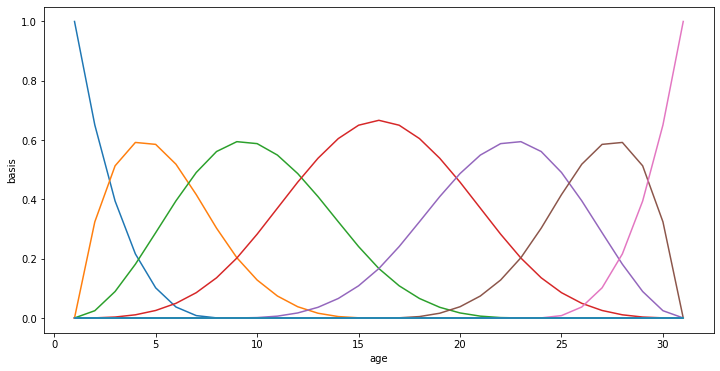

In [8]:
degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [9]:
spline_model_file = os.path.join('hierarchical_model/models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=spline_model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/hierarchical_model/stancode/layer3_nc_diffsd_parammubar


In [10]:
data = {
    "K" : basis_df.shape[1],
    "N" : int(data_count),  # number of total values
    "T" : int(max_age),  # length of time of data(31)
    "S" : int(ship_count), #failure_df.shape[1],  # number of ships(99)
    "E" : int(engine_count),  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": int(data_count),
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [11]:
spline_model_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [12]:
spline_az_inference = az.from_cmdstanpy(spline_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# check out arviz stuff

In [13]:
gp_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
spline_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [28]:
az.loo(gp_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -788.69    18.12
p_loo      122.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      618   94.6%
 (0.5, 0.7]   (ok)         29    4.4%
   (0.7, 1]   (bad)         6    0.9%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [29]:
az.loo(spline_az_inference, pointwise=True)

Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -861.42    17.42
p_loo       10.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      653  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [21]:
import logging
logger=  logging.getLogger()
logger.setLevel(logging.DEBUG)
az.compare({"gaussian_process": gp_az_inference, "spline": spline_az_inference}, ic="loo")

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
gaussian_process,0,-788.688,122.541,0,1,17.7328,0,True,log
spline,1,-861.423,10.0986,72.7348,6.04745e-17,17.4842,14.4198,False,log


In [16]:
#np.any(np.isnan(gp_model_fit.get_drawset(params=["log_lik"]).values))
#pd.set_option('display.max_rows', None)
az.summary(gp_az_inference)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"GP_engine_std[0,0]",-0.523,0.874,-2.229,1.121,0.016,0.023,2893.0,717.0,2844.0,2833.0,1.01
"GP_engine_std[0,1]",-0.116,1.011,-1.899,1.798,0.111,0.079,83.0,83.0,85.0,2669.0,1.03
"GP_engine_std[0,2]",-0.251,1.076,-2.220,1.542,0.195,0.139,30.0,30.0,32.0,33.0,1.08
"GP_engine_std[0,3]",-0.230,0.695,-1.502,1.124,0.011,0.012,4156.0,1601.0,4179.0,2936.0,1.06
"GP_engine_std[0,4]",0.060,0.767,-1.409,1.564,0.012,0.017,4211.0,1045.0,4170.0,2756.0,1.05
...,...,...,...,...,...,...,...,...,...,...,...
sigma_engine,0.507,0.308,0.095,1.216,0.074,0.058,17.0,15.0,27.0,20.0,1.10
sigma_ship,0.213,0.104,0.031,0.388,0.007,0.005,217.0,217.0,278.0,1700.0,1.02
sigma_error_ship,0.724,0.025,0.675,0.768,0.001,0.000,1286.0,1281.0,1305.0,2695.0,1.00
sigma_GP_engine,0.644,0.389,0.168,1.632,0.110,0.091,13.0,10.0,24.0,15.0,1.11


In [17]:
pd.reset_option('display.max_rows')

In [18]:
#np.any(np.isnan(gp_model_fit.get_drawset(params=["log_lik"]).values))